# Part 1: Test Basic Scraper & APIs

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
import re
from scrapy.crawler import CrawlerProcess

class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'http://www.everydaysexism.com',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for article in response.xpath('//article'):
            
            # Yield a dictionary with the values we want.
            yield {
                'name': article.xpath('header/h2/a/@title').extract_first(),
                'date': article.xpath('header/section/span[@class="entry-date"]/text()').extract_first(),
                'text': article.xpath('section[@class="entry-content"]/p/text()').extract(),
                'tags': article.xpath('*/span[@class="tag-links"]/a/text()').extract()
            }
        # Get the URL of the previous page.
        next_page = response.xpath('//div[@class="nav-previous"]/a/@href').extract_first()
        
        # There are a LOT of pages here.  For our example, we'll just scrape the first 9.
        # This finds the page number. The next segment of code prevents us from going beyond page 9.
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None and pagenum < 10:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.          
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'data.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')

Success!


In [2]:
import pandas as pd

# Checking whether we got data from all 9 pages
ESSdf=pd.read_json('data.json', orient='records')
print(ESSdf.shape)
print(ESSdf.head())

(90, 4)
        date               name            tags  \
0 2019-06-02             Bessie              []   
1 2019-06-02     Creepy old men  [Public space]   
2 2019-06-02               Dumb  [Public space]   
3 2019-06-02             London        [School]   
4 2019-06-02  Oddball neighbour          [Home]   

                                                text  
0  [Ok I hope I don’t upset anyone but in really ...  
1  [Married very old  friend of my dads thought m...  
2  [A couple of years ago, \nWe did a pub quiz an...  
3  [Twenty years ago, \nMy Muslim friend was marr...  
4  [I have been emailed by a neighbours  husband ...  


In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class WikiSpider(scrapy.Spider):
    name = "WS"
    
    # Here is where we insert our API call.
    start_urls = [
        'https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect'
        ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        for item in response.xpath('//lh'):
            # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
            # Other codes indicate links from 'Talk' pages, etc.  Since we are only interested in entries, we filter:
            if item.xpath('@ns').extract_first() == '0':
                yield {
                    'title': item.xpath('@title').extract_first() 
                    }
        # Getting the information needed to continue to the next ten entries.
        next_page = response.xpath('continue/@lhcontinue').extract_first()
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
            next_page = '{}&lhcontinue={}'.format(self.start_urls[0],next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'PythonLinks.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 10
})
                                         

# Starting the crawler with our spider.
process.crawl(WikiSpider)
process.start()
print('First 100 links extracted!')

First 100 links extracted!


In [2]:
import pandas as pd

# Checking whether we got data 

Monty=pd.read_json('PythonLinks.json', orient='records')
print(Monty.shape)
print(Monty.tail())

(94, 1)
                         title
89           Beyond the Fringe
90                        Cunt
91        List of Welsh people
92  Downing College, Cambridge
93                 Dan Aykroyd


# Part 2: Challenge
Do a little scraping or API-calling of your own. Pick a new website and see what you can get out of it. Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)<br>
2) Iterate over multiple pages/queries<br>
3) Save the data to your computer<br>

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest. Write up a report from scraping code to summary and share it with your mentor.

​

In [3]:
# https://losangeles.craigslist.org/
    
# Importing in each cell because of the kernel restarts.
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy.spiders import Rule
from scrapy.linkextractors import LinkExtractor


class CLSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "CL"
    
    # URL(s) to start with.
    allowed_domains = ["losangeles.craigslist.org"]
    start_urls = [
        'https://losangeles.craigslist.org/search/apa?min_bedrooms=1&max_bedrooms=2&min_bathrooms=1&max_bathrooms=2&availabilityMode=0&sale_date=all+dates'
    ]
    
    rules = (Rule (LinkExtractor(allow=("index\d00\.html", ),restrict_xpaths=('//p[@id="nextpage"]',)), callback="parse_items", follow= True),)

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <article> element on the page.
        for posting in response.xpath('//p'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract
                # You can modify this with other Xpath expressions to extract other information from the site
                'title': posting.xpath('a[@class="result-title hdrlnk"]/text()').extract_first(),
                'date': posting.xpath('time[@class="result-date"]/text()').extract_first(),
                'price': posting.xpath('span/span[@class="result-price"]/text()').extract_first()
            }
        
        # follow next page links
        next_page = response.xpath('.//a[@class="button next"]/@href').extract()
        if next_page:
            next_href = next_page[0]
            next_page_url = 'http://losangeles.craigslist.org' + next_href
            request = scrapy.Request(url=next_page_url)
            yield request  

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'tempe_apt.json',  # Name our storage file.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcamp (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False           # Turn off logging for now.
})

# Start the crawler with our spider.
process.crawl(CLSpider)
process.start()
print('Success!')

Success!


In [4]:
import pandas as pd

# Checking whether we got data 
df_apt = pd.read_json('tempe_apt.json')
print(df_apt.shape)
df_apt.head()

(3002, 3)


,date,price,title
0,Jan 29,$4695,The Glendon: Westwood's premier Class A property!
1,Jan 29,$1950,"Covered Parking, Refrigerator, Microwave"
2,Jan 29,$2803,2 bedroom| Central A/C and Heat| Free Parking ...
3,Jan 29,$1995,Newly renovated 1 bedroom apartment in Mar Vista
4,Jan 29,$1899,Lovely 2 Bedroom Apartment… Waiting for You to...


Specifically searched for apartment max 2 bedrooms min 1 bedroom & max 2 restrooms min 1 restrooms 

In [5]:
# Check data types
df_apt.dtypes

date     object
price    object
title    object
dtype: object

### Data Cleaning and Missing values

In [6]:
import re
 
# Scrub the dollar sign away
df_apt.price = df_apt.price.map(lambda x: None if x == None else int(re.sub('\$', '', str(x))))
df_apt.head()

,date,price,title
0,Jan 29,4695.0,The Glendon: Westwood's premier Class A property!
1,Jan 29,1950.0,"Covered Parking, Refrigerator, Microwave"
2,Jan 29,2803.0,2 bedroom| Central A/C and Heat| Free Parking ...
3,Jan 29,1995.0,Newly renovated 1 bedroom apartment in Mar Vista
4,Jan 29,1899.0,Lovely 2 Bedroom Apartment… Waiting for You to...


In [7]:
# Check data types
df_apt.dtypes

date      object
price    float64
title     object
dtype: object

In [8]:
# Check for missing values
total_missing = df_apt.isnull().sum().sort_values(ascending=False) 
                    #find the total null data values in each column based on percentage of data points in each column 

percent_missing = (df_apt.isnull().sum()/df_apt.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data

,Total,Percent
title,2,0.000666
price,2,0.000666
date,2,0.000666


In [9]:
# Drop missing values
df_apt = df_apt.dropna()

### Visualizations & Statistical Summaries

In [23]:
df_apt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 3 columns):
date     3000 non-null object
price    3000 non-null float64
title    3000 non-null object
dtypes: float64(1), object(2)
memory usage: 93.8+ KB


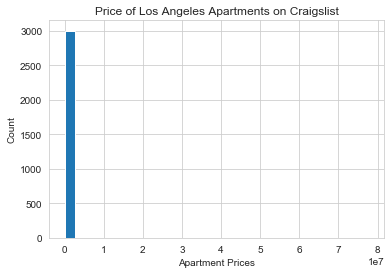

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_apt.price, 30)
plt.xlabel('Apartment Prices')
plt.ylabel('Count')
plt.title('Price of Los Angeles Apartments on Craigslist')
plt.show()

In [15]:
print('Average Aparment Price: ${0:.4g}\n'.format(df_apt.price.mean()))
print('Apartment Price Standard Deviation: +/-${0:.3g}\n'.format(df_apt.price.std()))
print('Apartment Price Median: +/-${0:.4g}'.format(df_apt.price.median()))

Average Aparment Price: $3.239e+04

Apartment Price Standard Deviation: +/-$1.44e+06

Apartment Price Median: +/-$2192


All of the data that could be scraped was collected, totaling 3002 observations. This allowed for a confident estimate of the average price of max 2 min 1 bedroom & max 2 min 1 restroom apartments listed on the Los Angeles craigslist portal. Also the Scrapying worked well to follow the "next page" links. The visualization didn't go well probably because there are some outliers. Further analyses are always possible  